## OHP He estimation from temperature measurements-two Hes- smooth varying He-averaged

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using LinearAlgebra
using ProgressMeter
using DifferentialEquations


In [3]:
using Images

In [4]:
cd(dirname(pwd()))
cd(dirname(pwd()))
cd("src") 


include("Systems.jl")
using ..Systems

include("Tools.jl")
using ..Tools


include("Thermomodel.jl")
using ..Thermomodel

include("Postprocessing.jl")
using ..Postprocessing


## Initialization

In [5]:
    ω0 = [sqrt(1.2e004)];
    ℘ = [1.2e005];


    Θ = 0.15;
    θe = 1 + Θ;
    θc = 1 - Θ;
    
    He = 3000.0;
    Hc = 3000.0;


    γ = 1.3;#not 1.4!!!!! maybe 1.33?

In [6]:
    L = 4.0  # total length of the pipe when streched to a 1D pipe
    L2D = 2.0 # the actual length of the bended pipe in the real world
    alpha = pi/2 # inclination angle 

1.5707963267948966

In [7]:
tube = Tube(L,L2D,alpha)

Tube(4.0, 2.0, 1.5707963267948966)

In [8]:
Xe = map(tuple, [0.0; 3.0], [1.0; 4.0])
evap = Evaporator(He,θe,Xe)

Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 4.0)])

In [9]:
Xc = map(tuple, [1.0], [3.0])
cond = Condenser(Hc,θc,Xc)

Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0)])

In [10]:
X0 = [(1.5,3.5)]
dXdt0 = [(0.0,0.0)]
liquids=LiquidSlug(γ,ω0,℘,X0,dXdt0)

LiquidSlug(1.3, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(1.5, 3.5)], Tuple{Float64,Float64}[(0.0, 0.0)])

In [11]:
P = [1.0,1.0]

vapors=VaporPlug(γ,P)

VaporPlug(1.3, [1.0, 1.0])

In [12]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors)

PHPSystem(Tube(4.0, 2.0, 1.5707963267948966), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 4.0)]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0)]), LiquidSlug(1.3, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(1.5, 3.5)], Tuple{Float64,Float64}[(0.0, 0.0)]), VaporPlug(1.3, [1.0, 1.0]))

## Median filter

In [13]:
patch_size = 3

3

In [14]:
function medianfilter(estimation_state, patch_size)
    
    filter_state = zeros(Float64, (length(estimation_state),length(estimation_state[1]),length(estimation_state[1][1])))
    
    # filter_state = zeros(length(estimation_state),size(estimation_state[1]))
    for i = 1:length(estimation_state)
        filter_state[i,:,:] = collect(deepcopy(hcat(estimation_state[i]...)'))
    end
    
    for i = 1:size(filter_state,1)
        for j = 1:size(filter_state,3)
            filter_state[i,:,j] = deepcopy(mapwindow(median, filter_state[i,:,j], patch_size))
        end
    end
    
    filtered_state = deepcopy(estimation_state)

    for i = 1:size(filtered_state,1)
        for j = 1:size(filtered_state[1],1)
            filtered_state[i][j] = deepcopy(filter_state[i,j,:])
        end
    end
    
    
    return filtered_state
end

medianfilter (generic function with 1 method)

## Standard deviation

In [155]:
    function std_EnKF(estimation_state)

    matr_state = zeros(Float64, (length(estimation_state),length(estimation_state[1]),length(estimation_state[1][1])))
    
    # filter_state = zeros(length(estimation_state),size(estimation_state[1]))
    for i = 1:length(estimation_state)
        matr_state[i,:,:] = collect(deepcopy(hcat(estimation_state[i]...)'))
    end

    std_state = zeros(Float64, (length(estimation_state), length(estimation_state[1][1])))
    for i = 1:size(matr_state,1)
        for j = 1:size(matr_state,3)
            std_state[i,j] = std(matr_state[i,:,j])
        end
    end
    return std_state
end

std_EnKF (generic function with 1 method)

## Get numerical solution

In [15]:
Lvaporplug = XptoLvaporplug(X0,L)
M = P.^(1/γ).* Lvaporplug

u=vcat(XMtovec(sys0.liquidslug.Xp,sys0.liquidslug.dXdt,M), He...)

7-element Array{Float64,1}:
    1.5
    3.5
    0.0
    0.0
    1.5
    0.5
 3000.0

## Heaviside function

In [16]:
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))

heaviside (generic function with 1 method)

## EnKF PropagationFunction

In [17]:
function zhang2002modelEnKFtruth!(du::Array{Float64,1},uEnKF::Array{Float64,1},p::PHPSystem,t::Float64)

    sys = p

    # added He as a state vector entry
    u = uEnKF[1:end-1]
#     uHe = deepcopy(uEnKF[end]) + 9*deepcopy(uEnKF[end])*heaviside.(t-tspan[end]/2)
    uHe = deepcopy(uEnKF[end]) .* (sin(4*2*π*t/(tspan[end]))+1)

    numofliquidslug =  Integer( (length(u) - 1)/5 )
    
    (Xp,dXdt0,M)=vectoXM(u)

    γ = sys.liquidslug.γ
    ω0 = sys.liquidslug.ω0
    ℘ = sys.liquidslug.℘
    Lvaporplug = XptoLvaporplug(Xp,sys.tube.L)
#     Lliquidslug = XptoLliquidslug(Xp)
    height = getheight(Xp,sys.tube.L2D,sys.tube.alpha)
    Xpvapor = getXpvapor(Xp,sys.tube.L)


    P = real.((M./Lvaporplug .+ 0im).^(γ))

    θ = real.((P .+ 0im).^((γ-1)/γ))


    for i = 1:numofliquidslug
        du[2*i-1] = u[2*numofliquidslug+2*i-1]
        du[2*i] = du[2*i-1]

        du[2*numofliquidslug + 2*i-1] = -32*u[2*numofliquidslug + 2*i-1] - (ω0[i]^2)*(0.5*(height[i][end]-height[i][1])) + ℘[i]*(P[i]-P[i+1])
        du[2*numofliquidslug + 2*i] = du[2*numofliquidslug + 2*i-1]

    end


        du[4*numofliquidslug+1:5*numofliquidslug+1] .= dMdtzhang2002modelEnKF(Xpvapor,θ,sys,uHe)
    
    du[end]=0.0

    return du

end

zhang2002modelEnKFtruth! (generic function with 1 method)

In [18]:
function zhang2002modelEnKF!(du::Array{Float64,1},uEnKF::Array{Float64,1},p::PHPSystem,t::Float64)

    sys = p

    # added He as a state vector entry
    u = uEnKF[1:end-1]
    uHe = deepcopy(uEnKF[end])

    numofliquidslug =  Integer( (length(u) - 1)/5 )
    
    (Xp,dXdt0,M)=vectoXM(u)

    γ = sys.liquidslug.γ
    ω0 = sys.liquidslug.ω0
    ℘ = sys.liquidslug.℘
    Lvaporplug = XptoLvaporplug(Xp,sys.tube.L)
#     Lliquidslug = XptoLliquidslug(Xp)
    height = getheight(Xp,sys.tube.L2D,sys.tube.alpha)
    Xpvapor = getXpvapor(Xp,sys.tube.L)


    P = real.((M./Lvaporplug .+ 0im).^(γ))

    θ = real.((P .+ 0im).^((γ-1)/γ))


    for i = 1:numofliquidslug
        du[2*i-1] = u[2*numofliquidslug+2*i-1]
        du[2*i] = du[2*i-1]

        du[2*numofliquidslug + 2*i-1] = -32*u[2*numofliquidslug + 2*i-1] - (ω0[i]^2)*(0.5*(height[i][end]-height[i][1])) + ℘[i]*(P[i]-P[i+1])
        du[2*numofliquidslug + 2*i] = du[2*numofliquidslug + 2*i-1]

    end


        du[4*numofliquidslug+1:5*numofliquidslug+1] .= dMdtzhang2002modelEnKF(Xpvapor,θ,sys,uHe)
    
    du[end]=0.0

    return du

end


function dMdtzhang2002modelEnKF(Xpvapor::Array{Tuple{Float64,Float64},1},θ::Array{Float64,1},sys::PHPSystem,uHe)

    dMdt=zeros(length(Xpvapor))


    Xe = sys.evaporator.Xe
    He = uHe
    θe = sys.evaporator.θe

    Xc = sys.condenser.Xc
    Hc = sys.condenser.Hc
    θc = sys.condenser.θc

    Levapoverlap=XpvaportoLoverlap(Xpvapor,Xe)
    Lcondoverlap=XpvaportoLoverlap(Xpvapor,Xc)


    # May not be right for multi liquid flow
    for i = 1:length(Xpvapor)
        if Lcondoverlap[i] < 1e-8
            dMdt[i] = He * Levapoverlap[i] * (θe-θ[i])
        else
            dMdt[i] = -Hc * Lcondoverlap[i] * (θ[i]-θc)
        end
    end

    return dMdt

end

dMdtzhang2002modelEnKF (generic function with 1 method)

In [19]:
tstep=1.0e-5

p = sys0
tspan = (0.0, 0.1);
T = tspan[1]:tstep:tspan[end]

prob = ODEProblem(zhang2002modelEnKFtruth!, u, tspan, p)
sol = solve(prob, RK4(), adaptive=false, dt=tstep);
integrator = init(prob, RK4(), adaptive =false, dt = tstep, save_everystep=false)

t: 0.0
u: 7-element Array{Float64,1}:
    1.5
    3.5
    0.0
    0.0
    1.5
    0.5
 3000.0

## EnKF

In [130]:
probEnKF = ODEProblem(zhang2002modelEnKF!, u, tspan, p)
solEnKF = solve(probEnKF, RK4(), adaptive=false, dt=tstep);
integrator = init(probEnKF, RK4(), adaptive =false, dt = tstep, save_everystep=false)

t: 0.0
u: 7-element Array{Float64,1}:
    1.5
    3.5
    0.0
    0.0
    1.5
    0.5
 3000.0

In [131]:
newHe = 0.0

0.0

In [132]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    for (i,s) in enumerate(ENS.S)
        
        set_t!(integrator, deepcopy(t))
        set_u!(integrator, deepcopy(s))
#         for j=1:10
        step!(integrator)
#         end
        ENS.S[i] = deepcopy(integrator.u)

    end
    
    return ENS
end

In [133]:
fprop = PropagationFunction()

PropagationFunction()

In [134]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    result=soltoResult(s[1:end-1],sys0);
#     return [s[3]]
    return [deepcopy(result.θ[1]),deepcopy(result.θ[2])]
end

In [135]:
function (::MeasurementFunction)(t::Float64) 
#     return reshape([0.0, 0.0, 1.0, 0.0, 0.0, 0.0],(1,6))
    return reshape([1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0,0.0],(2,7))
end

In [136]:
m = MeasurementFunction()

MeasurementFunction()

In [137]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    let s = sol(t)
#     fill!(ENS, [deepcopy(s[3])])
        result=soltoResult(s[1:end-1],sys0);
    fill!(ENS, [deepcopy(result.θ[1]),deepcopy(result.θ[2])])
    end
    return ENS
end

In [138]:
z = RealMeasurementFunction()

RealMeasurementFunction()

In [139]:
# A = MultiAdditiveInflation(2, 1.05, MvNormal(zeros(1), 2.0*I))
A = MultiAdditiveInflation(7, 1.001, MvNormal(zeros(7), 0.00001*Diagonal([1.0,1.0,100000.0,100000.0,1.0,1.0,10000000000.0])))
# A = IdentityInflation()

MultiAdditiveInflation{7}(1.001, DiagNormal(
dim: 7
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0e-5 0.0 … 0.0 0.0; 0.0 1.0e-5 … 0.0 0.0; … ; 0.0 0.0 … 1.0e-5 0.0; 0.0 0.0 … 0.0 100000.00000000001]
)
)

In [140]:
# this is measurement noise!!!!!!!!
# ϵ = AdditiveInflation(MvNormal(zeros(1), 1.0*I))
ϵ = AdditiveInflation(MvNormal(zeros(2), 0.00001*I))

AdditiveInflation{2}(IsoNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [1.0e-5 0.0; 0.0 1.0e-5]
)
)

In [141]:
N = 50
# NZ = 1
NZ = 2
isinflated = true
isfiltered = false
isaugmented = true

true

In [142]:
x₀ = [1.0, 3.0, 0.0, 0.0, 1.0, 1.0, newHe]
ens = initialize(N, MvNormal(x₀, 1^2*Diagonal([1.0,1.0,100.0,100.0,1.0,1.0,500.0].^2)))
estimation_state = [deepcopy(ens.S)]

estimation_state0 = [deepcopy(ens.S)]

true_state = [deepcopy(x₀)]
covs = []

0-element Array{Any,1}

In [143]:
g = FilteringFunction()

FilteringFunction()

In [144]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ, isinflated, isfiltered, isaugmented)

ENKF{50,2}(PropagationFunction(), MultiAdditiveInflation{7}(1.001, DiagNormal(
dim: 7
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0e-5 0.0 … 0.0 0.0; 0.0 1.0e-5 … 0.0 0.0; … ; 0.0 0.0 … 1.0e-5 0.0; 0.0 0.0 … 0.0 100000.00000000001]
)
), FilteringFunction(), MeasurementFunction(), RealMeasurementFunction(), AdditiveInflation{2}(IsoNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [1.0e-5 0.0; 0.0 1.0e-5]
)
), true, false, true)

In [145]:
Δt = 1e-5
Tsub = 0.0:Δt:0.1-Δt

filtered_state = []


    
for (n,t) in enumerate(Tsub)

    global ens
    
    t, ens, cov = enkf(t, Δt, ens)
    
    push!(estimation_state, deepcopy(ens.S))
    push!(covs, deepcopy(cov))
    
end
    
    filtered_state = deepcopy(medianfilter(estimation_state, patch_size));


10001-element Array{Array{Array{Float64,1},1},1}:
 [[2.4119029286020446, 3.8204485381002846, 62.70281187901584, -0.32527396431752126, 0.04006482091287489, -0.7450780946798528, -732.3791352753285], [1.5722832233278465, 3.0913755360417303, 62.70281187901584, 6.6686423856004495, 0.17989027468459173, -0.16388878891316327, -110.39214522046751], [0.5927703641116333, 2.828053766147562, -58.21294728769546, 155.92392196136552, 0.9973617570970543, 0.46282339680037854, -110.39214522046751], [0.0584463143580104, 3.0913755360417303, -71.94036905183677, 84.44246811785465, 0.9973617570970543, 1.1420953378092584, 224.4337767655942], [-0.8710201330488347, 2.828053766147562, -123.42524942949365, 84.44246811785465, 1.1242007465294386, 1.7671249899213168, 238.58408210974778], [0.0584463143580104, 3.9627536734230016, -177.03959811614502, 53.058112355151565, -0.0347429448778811, 1.7671249899213168, 238.58408210974778], [0.2161379924043123, 3.96868593296362, -177.03959811614502, 15.768787461531552, 1.0105940

In [156]:
std_state = std_EnKF(estimation_state)

10001×7 Array{Float64,2}:
 1.0077     0.770922    93.6434   103.238    0.964534    0.913963    512.932
 0.954939   0.65327     92.2918   110.374    0.708322    0.832947    725.212
 0.943154   0.581796   142.696    177.851    0.662206    0.66591     828.774
 0.904458   0.551142   140.369    176.345    0.594532    0.603211    890.144
 0.878587   0.549044   130.663    162.266    0.58346     0.545132    890.403
 0.870409   0.49975    130.96     162.202    0.574213    0.534359    888.12 
 0.868348   0.496569   121.711    155.579    0.56863     0.501381    947.29 
 0.865661   0.484759   120.823    155.862    0.567282    0.497783    996.568
 0.867261   0.480432   120.488    154.24     0.565002    0.492643   1098.4  
 0.868314   0.478512   120.042    145.542    0.554276    0.489683   1112.65 
 0.865009   0.411725   119.874    143.783    0.553365    0.423023   1110.03 
 0.868417   0.378686   115.635    132.645    0.554597    0.39228    1057.12 
 0.865386   0.350968   114.704    128.757    0.532

## Show the results

In [157]:
s =  hcat(sol(T).u...)
ŝ =  hcat(mean.(estimation_state)...)
ŝ_filter = hcat(mean.(filtered_state)...)

results=soltoResult(sol[1:end-1,:],sys0);
resultŝ=soltoResult(ŝ[1:end-1,:],sys0);
resultŝ_filter=soltoResult(ŝ_filter[1:end-1,:],sys0);



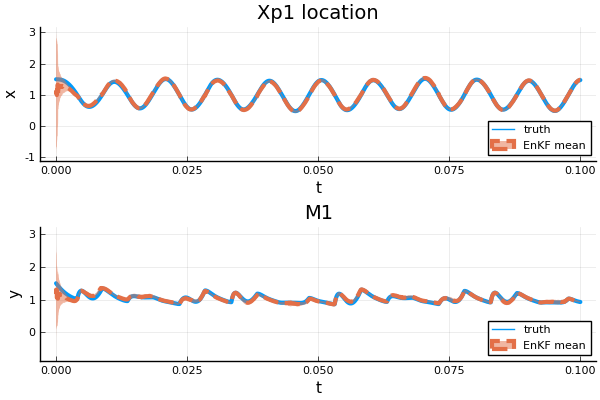

In [158]:
plt1 = plot(layout = (2, 1), legend = :bottomright)
plot!(plt1[1], T, results.Xp[1][1:end-1], linewidth = 3, label = "truth")
plot!(plt1[1], Tsub, ŝ[1,1:end-1], linewidth = 3,ribbon = 2*std_state[:,1], markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash,title="Xp1 location")

plot!(plt1[2], T, results.M[1][1:end-1], linewidth = 3, label = "truth")
plot!(plt1[2], Tsub,  ŝ[5,1:end-1], linewidth = 3,ribbon = 2*std_state[:,5], markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "y", linestyle =:dash,title="M1")

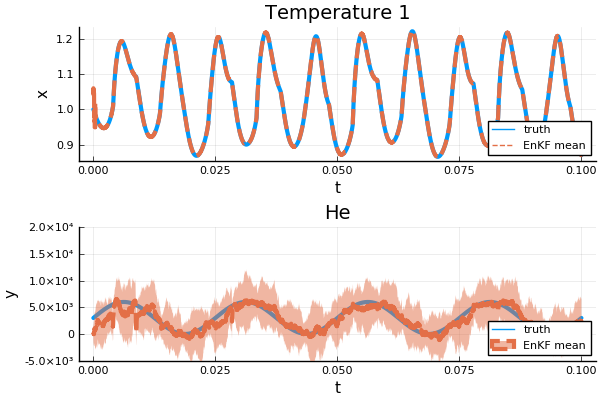

In [159]:
plt2 = plot(layout = (2, 1), legend = :bottomright)

plot!(plt2[1], T, results.θ[1][1:end-1], linewidth = 3, label = "truth")
plot!(plt2[1], Tsub, resultŝ.θ[1][1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash,title="Temperature 1")

plot!(plt2[2], T, (sol[end,1:end-1] .* (sin.(4*2*π.*T./(T[end])) .+ 1)), linewidth = 3, label = "truth")
plot!(plt2[2], Tsub, ŝ[7,1:end-1], linewidth = 3, markersize = 2, ribbon = 2*std_state[:,7], label = "EnKF mean", xlabel = "t", ylabel = "y", linestyle =:dash,title="He", ylim=(-5000.0, 20000.0))
# plot!(plt2[2], T, (sol[end,1:end-1] .* (sin.(4*2*π.*T./(T[end])) .+ 1)), linewidth = 3, label = "truth")

In [150]:
4*2*π.*T./(T[end])

0.0:0.0025132741228718345:25.132741228718345

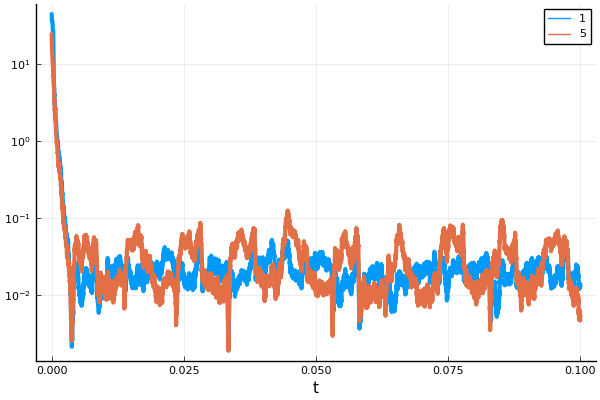

In [151]:
plot(Tsub, map(covs) do P  
        P[1,1]+ eps() end, yscale = :log10, linewidth = 3, label = "1")
plot!(Tsub, map(covs) do P
        P[5,5]+ eps() end, yscale = :log10, linewidth = 3, xlabel = "t", label = "5")

In [152]:
ens.S

50-element Array{Array{Float64,1},1}:
 [1.4754444006122713, 3.487994974775238, 21.38943803220471, 87.19534560967502, 0.9267993106802072, 0.9559242797986532, 3133.7492250183836]    
 [1.4663952259561401, 3.476705528503359, 25.004507767079883, 99.5166972344907, 0.9110530476722505, 0.9707404101289264, 5667.447450521844]     
 [1.486918200564859, 3.48080352627125, 23.037542306280105, 98.43905024359255, 0.9434028583405426, 0.954813420558401, 7070.401219926791]       
 [1.4863186120044263, 3.4549681107112558, 23.48780822014615, 97.9913222458161, 0.9272308116042524, 1.006728120978099, 1165.2620138186562]     
 [1.503878022005372, 3.4488013383521303, 25.98400247013145, 92.83726999326343, 0.9423886776668079, 1.0289321962514517, -1037.2617823017843]   
 [1.4694967970356918, 3.4608430114915847, 14.392797344167548, 109.52091780125369, 0.9335579901439636, 1.0048931476359255, 1622.7565796277033] 
 [1.4976318245191755, 3.4401741658103364, 4.660470521031415, 94.65508200214249, 0.934508225296889, 1.037

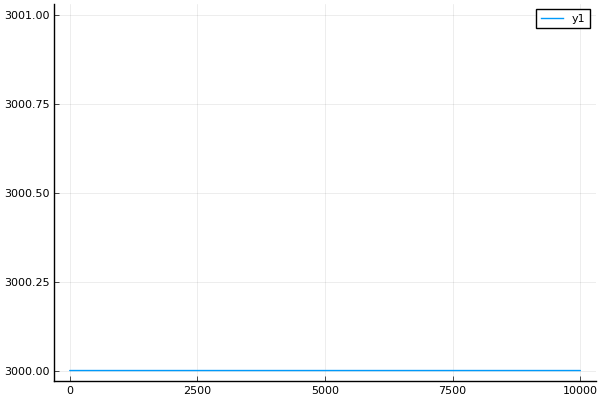

In [153]:
plot(sol[7,:])

In [154]:
ens = initialize(N, MvNormal(x₀, 0.1*Diagonal([1.0,1.0,100000.0,100000.0,1.0,1.0,100000000.0])))
ens.S

50-element Array{Array{Float64,1},1}:
 [1.3212207566758263, 2.9234074121159472, 180.803838347882, 44.06027397683398, 0.8421281312221016, 1.0836588896387096, 1396.3489305033593]      
 [1.0345150882544814, 2.7844744397514827, 0.7271203002374453, -97.89063820616506, 1.0023510193599225, 1.6206964899330982, 272.4505792728839]    
 [1.131852340287189, 3.5770403838806595, -114.31289385655539, -9.797953270180482, 1.0411842110267102, 1.0035237466759588, 1349.43833299785]     
 [0.5912891833162949, 3.2483196560415184, -95.38203479505256, 178.95610757875073, 1.0531849202734762, 0.9019919957304127, -1550.743956334987]   
 [0.9165139411809995, 2.7662827272734924, -79.46375473699656, -129.5392217569667, 1.1071543193394224, 2.1614892726549755, 4361.104461397141]    
 [0.8775964114137085, 2.65033473923724, -25.850979540583097, -64.06247898541595, 0.853323073366981, 0.17642327461841167, 2785.8882511736388]    
 [1.2466767396011245, 2.780152811977785, -242.53394098545678, 71.83467524686195, 0.568628935